<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">7th January, 2019</span>
</div><h1>DynapseControl:</h1><h1>Interface for cortexcontrol</h1>

This document illustrates how to use the `DynapseControl` class to interface `cortexcontrol` and the DynapSE processor.

##### Housekeeping and import statements


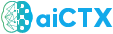

In [1]:
# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

The `DynapseControl` class provides higher-level functionality for `cortexcontrol` and allows the `NetworksPython` framework to interact with the DynapSE processor. However, it can also be used from outside `NetworksPython`.

<br>

## Setup

<br>

### Connecting to Cortexcontrol

In order to work interface the DynapSE chip, this layer relies on `Cortexcontrol`. It can either be used from within the `Cortexcontrol` console or via an `RPyC` connection. In order to run some examples from within this jupyter notebook, we will do the latter. For this we start `Cortexcontrol` and run the following commands in its console (not in this notebook):

If the `cortexcontrol` console prints <br>
<i>"RPyC: Ready to start."</i> <br>
and nothing else, it is ready. Now through your usual python setup (console, iPython, jupyter, ...) you can import the class and instantiate a `DynapseControl` object.

<br>

### Import and class  instantiation

The `DynapseControl` class can be imported from the `NetworksPython` package and is defined in the `dynapse_control` module. Objects can be instantiated without any arguments:


In [1]:
# - Import class
from NetworksPython import DynapseControl

# - Easy instantiation
dc = DynapseControl()

/home/felix/miniconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
WARNING    /home/felix/gitlab/network-architectures/NetworksPython/layers/__init__.py:107: UserWarning: Could not load package .internal.dynap_hw
  warn("Could not load package " + strModule)
 [py.warnings]


ImportError: cannot import name 'DynapseControl' from 'NetworksPython' (/home/felix/gitlab/network-architectures/NetworksPython/__init__.py)

There are two optional arguments:

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `tFpgaIsiBase` | `float`| `2e-5` | Time step for sending data to hardware |
| `lnClearCores` | `list` or `None` | `None` | IDs of cores whose configuration should be cleared. |

`tFpgaIsiBase` is a `float` determines the time step size of the inter-spike intervals between events that are sent to the processor. For more details, see <i>FPGA</i>.

`lnClearCores` can either be `None` or a list of integers. In the latter case the configurations of cores with corresponding IDs are wiped, so that  previously set synaptic connections, that the user may not aware of, are removed. To be more precise, the CAMs (pre-neuron IDs and pre-neuron core IDs) and the SRAMs (target chip ID, virtual core ID, core mask) are cleared. `lnClearCores` should include the IDs of all cores that you are going to work on. In order to save some time, you can omit the others. In case of an empty list or `None` as argument, no cores are cleared.

<br>

## Hardware

Before we go into the details of how the class works, let us first have a brief look at some properties of the DynapSE.

The DynapSE processor consists of 4 chips. Each chips has 4 cores of 256 neurons. The chips, as well as each core in a chip and each neuron in a core are identified with an ID between 0 and 3 or 0 and 256, respectively. However, this class uses logical IDs from 0 to 4095 that range over all neurons. In other words the logical neuron ID is $1024 \cdot \text{ChipID} + 256 \cdot \text{CoreID} + \text{NeuronID}$.

<br>

### Setting connections

#### Understanding the routing scheme
- When sending: SRAM
- When receiving: CAM (point out limit of 64 inputs)


<br>

#### Synapse types
There are four different synapse types on the DynapSE: fast and slow excitatory as well as fast and slow inhibitory. Each neuron can receive inputs through up to 64 synapses, each of which can be any of the given types. Via `cortexcontrol` the synaptic behavior can be adjusted for each type and for each core, but not for individual synapses.

There is a priori no difference between slow and fast excitatory synapses, so they can be set to have the same behavior. In fact, one could assign shorter time constants to the "slow" excitatory synapses, making them effectively the fast ones. While both excitatory and the fast inhibitory synapses work by adding or subtracting current to the neuron membrane, the slow inhibitory synapses use shunt inhibition and in practice silence a neuron very quickly.

Note that all synapses that are of the same type and that are on the same core have the same weight. Different connection strengths between neurons can only be achieved by setting the same connection multiple times. 

<br>

### Sending events

<br>

#### Virtual neurons
Inputs are sent to the hardware through so-called virtual neurons. Every virtual neuron on the DynapSE has a logical ID, which ranges from 0 to 1023.  An event that is sent to the hardware translates into a virtual neuron emitting a spike.

If a physical neuron $m$ is set to receive spikes from a neuron with logical ID $n$, it makes no difference if a virtual or a pysical neuron with this ID is firing (as long as the firing neuron's target chip IDs and core masks include the location $m$). Neuron $m$ will receive the spikes in both cases. Because this can cause unexpected behavior it is recommended that the IDs of the physical neurons are pairwise different from the IDs of of the virtual neurons.

<br> 

#### FPGA
As for now it is not possible with `DynapseControl` to stream events continuously to the DynapSE. Instead, events are first sent to an FPGA, temporarily stored there and then translated to spikes of virtual neurons, with temporal order and inter-spike intervals matching the input signal. The number of events that can be sent at once is limited to $2^{16} - 1 = 65535$. Longer inputs need to be split up.

Inter-spike intervals must be multiples of a time step, which in `DynapseControl` is stored as `tFpgaIsiBase`. This time step, in return,  needs to be a multiple of $11.\overline{1} \cdot 10^{-9} \text{ s}$.

Although the size of `tFpgaIsiBase` has no effect on computation time, it is not always advisable to choose the smallest possible value. The reason is that the number of timesteps between two input spikes is limited to $2^{16}-1 = 65535$. This means that with `tFpgaIsiBase` $= 11.\overline{1} \cdot 10^{-9} \text{ s}$, any inter-spike interval longer than about 0.73 milliseconds will cause the layer to throw an exception. Therefore it makes sense to set `tFpgaIsiBase` to something between $10^{-6}$ and $10^{-4}$ seconds, in order to allow for sufficiently long silent parts in the input while still maintaining a good temporal resolution. Alternatively one could send dummy events that do not target any physical neuron. However, transmission of events to the processor is not the fastest and the more events are sent, the longer it takes.

<br>

### Receiving events

- EventFilter and BufferedEventFilter

### Time constants for neurons

### Neuron allocation

### Shadow state neurons

<br>

## Methods overview
Now that a `DynapseControl` has been instantiated, there are many ways of using it to interact with the hardware. This section will give an overview over all mehtods that are currently implemented. For more details please consult the documentation within the source code. 

<br>

### Neuron allocation and connections

`allocate_hw_neurons`<br>
Allocate neurons if available and return them in lists.

`allocate_virtual_neurons`<br>
Allocate virtual neurons if available and return them in list.

`connect_to_virtual`<br>
Connect populations of virtual and physical neurons.

`set_virtual_connections_from_weights`<br>
Set connections from virtual to physical neurons from weight matrix.

`set_connections_from_weights`<br>
Set connections between physical neurons from weight matrix.

`remove_all_connections_to`<br>
Remove all presynaptic connections to specified neurons.

<br>

### Resetting

`clear_connections` <br>
Reset connections for specified cores.

`reset_silencing` <br>
Assign time constant tau1 to all neurons on specified cores.

`reset_cores` <br>
Reset neuron assignments, time constants and presynaptic connections for specified cores.

`reset_all` <br>
Reset neuron assignments, time constants and presynaptic connections for all cores.

<br>

### Stimulation and event generation
`start_cont_stim`<br>
Start sending events to processor with fixed frequency.

`stop_stim`<br>
Stop any ongoing stimulation except poisson-rate stimulation.

`start_poisson_stim`<br>
Start generating events by poisson processes and send them.

`stop_poisson_stim`<br>
Stop generating events by poisson processes and send them.

`reset_poisson_rates`<br>
Set rates for poisson event generation to 0.

`send_pulse`<br>
Send a pulse of periodic input events.

`send_TSEvent`<br>
Extract events from a `TSEvent` object and send them to the processor. Can record neuron activity simultaneously.

`send_arrays`<br>
Extract events from arrays (times and channels) and send them to the processor. Can record neuron activity simultaneously.

<br>

### Tuning and observing activities

`add_buffered_event_filter`<br>
Add a `BufferedEventFilter` to record activities from specified neurons.

`clear_buffered_event_filter`<br>
Stop recording neuron activities.

`collect_spiking_neurons`<br>
Return a list of neurons that spike during a specified time.

`silence_hot_neurons`<br>
Set time constant to tau2 for neurons that spike during specified time.

`measure_population_firing_rates`<br>
Measure firing rates for multiple neuron populations.

`measure_firing_rates`<br>
Measure firing rates of specified neurons.

`monitor_firing_rates`<br>
Start periodically printing the average firing rates for specified neurons.

`stop_monitor`<br>
Stop measuring and printing firing rates.

`sweep_freq_measure_rate`<br>
Stimulate a group of neurons by sweeping over a list of input frequencies. Measure their firing rates.

<br>

### Load and save biases

`load_biases`<br>
Load biases from file.

`save_biases`<br>
Save biases to file.

`copy_biases`<br>
Copy biases from one core to other(s).

<br>

## Using RPyC

- important when developing new methods, otherwise not

- Using RPyC (do not send special data types, how to define functions, avoid loops where data is sent back and forth, make sure to not send references, how to define variables and (builtin) modules
- print for testing where function "lives"

#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb